In [ ]:
import pandas as pd
import numpy as np
import os
import cv2 as cv


annotations1 = pd.read_csv('./Columbia DataSet/_annotations.csv')
img_size = 224

def load_data(IMAGES_PATH, annotations):
    images = []
    gaze_labels = []
    
    
    for index, row in annotations.iterrows():
        
            img_path = os.path.join(IMAGES_PATH, row[0])
            image = cv.imread(img_path)
                
            image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
            
            image_resized = cv.resize(image, (img_size, img_size))

            images.append(image_resized)
            
            label = row[1]
            
            if label < -1:
                gaze_labels.append(0)
            elif label > 1:
                gaze_labels.append(2)
            else:
                gaze_labels.append(1)
                
            
    return np.array(images), np.array(gaze_labels)

X, Y = load_data('./Columbia DataSet', annotations1)

/var/folders/6g/4zq1d985075_7_l6gxj2n81m0000gn/T/ipykernel_67465/1717740113.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = os.path.join(IMAGES_PATH, row[0])
/var/folders/6g/4zq1d985075_7_l6gxj2n81m0000gn/T/ipykernel_67465/1717740113.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)

In [ ]:
import cv2 as cv
import numpy as np
import dlib


detectFace = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("Predictor/shape_predictor_68_face_landmarks.dat")


def faceDetector(gray):
    faces = detectFace(gray)
    return faces[0]

def faceLandmakDetector(gray, face):
    landmarks = predictor(gray, face)
    pointList = []

    for n in range(0, 68):
        point = (landmarks.part(n).x, landmarks.part(n).y)
        pointList.append(point)
  
    return pointList

def EyeTracking(gray, eyePoints):
    dim = gray.shape

    mask = np.zeros(dim, dtype=np.uint8)
    PollyPoints = np.array(eyePoints, dtype=np.int32)
   
    cv.fillPoly(mask, [PollyPoints], 1)
    eyeImage = cv.bitwise_and(gray, gray, mask=mask)

    maxX = (max(eyePoints, key=lambda item: item[0]))[0]
    minX = (min(eyePoints, key=lambda item: item[0]))[0]
    maxY = (max(eyePoints, key=lambda item: item[1]))[1]
    minY = (min(eyePoints, key=lambda item: item[1]))[1]

    eyeImage[mask == 0] = 255

    cropedEye = eyeImage[minY:maxY, minX:maxX]
    height, width = cropedEye.shape

    ret, thresholdEye = cv.threshold(cropedEye, 100, 255, cv.THRESH_BINARY)

    center_width = int(width * 0.2) 
    side_width = int((width - center_width) / 2) 

    rightPart = thresholdEye[0:height, 0:side_width]
    centerPart = thresholdEye[0:height, side_width:side_width + center_width]
    leftPart = thresholdEye[0:height, side_width + center_width:width]


    rightBlackPx = np.sum(rightPart == 0)
    centerBlackPx = np.sum(centerPart == 0)
    leftBlackPx = np.sum(leftPart == 0)
    pos = Position([rightBlackPx, centerBlackPx, leftBlackPx])

    return mask, pos

def Position(ValuesList):
    maxIndex = ValuesList.index(max(ValuesList))
    posEye = ''
    if maxIndex == 0:
        posEye = 0
    elif maxIndex == 1:
        posEye = 1
    elif maxIndex == 2:
        posEye = 2
    return posEye

In [ ]:
def detectGaze(frame):
    grayFrame = frame

    try:
        face = faceDetector(grayFrame)

        if face is not None:
            PointList = faceLandmakDetector(grayFrame, face)

            RightEyePoint = PointList[36:42]
            LeftEyePoint = PointList[42:48]

            maskRight, pos1 = EyeTracking(grayFrame, RightEyePoint)
            maskLeft, pos2 = EyeTracking(grayFrame, LeftEyePoint)

            if pos1 == 2 and pos1 == 2:
                return 2
            elif pos1 == 0 and pos2 == 0:
                return 0
            elif pos1 == 1 and pos2 == 1:
                return 1
            else:
                return 100
            
        else:
            return 100
        
    except:
        return 100

In [75]:

y_pred = []

for x in X_test:
        y_pred.append(detectGaze(x))


In [76]:
accuracy = np.mean(y_pred == Y_test)
print("Accuracy:", accuracy)

Accuracy: 0.5338894681960376


## Metrics for Evaluation

In [82]:
X_test.shape

(959, 224, 224)

In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
 

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(Y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(Y_test, y_pred, average='weighted', zero_division=0)
conf_matrix = confusion_matrix(Y_test, y_pred)


print(f"- Accuracy: {accuracy:.2f}")
print(f"- Precision: {precision:.2f}")
print(f"- Recall: {recall:.2f}")
print(f"- F1-Score: {f1:.2f}")

- Accuracy: 0.53
- Precision: 0.66
- Recall: 0.53
- F1-Score: 0.49


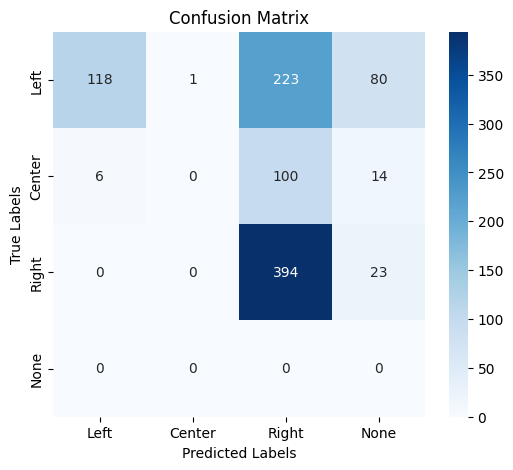

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Left", "Center", "Right", "None"], 
            yticklabels=["Left", "Center", "Right", 'None'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()